## Navier-Stokes Equations
$$
\nabla \overrightarrow{V} = 0
$$
$$
\rho \frac{D\overrightarrow{V}}{Dt} = -\nabla p + \rho \overrightarrow{g} + \mu \nabla^2 \overrightarrow{V}
$$

The Navier-Stokes equations describe the flow of fluids, relating changes in the velocity and pressure fields. Traditional 'solvers' use iterative numeric methods to solve for the velocity and pressure fields at each time step.

In two dimensions, the velocity field is a $W * H * 2$ tensor, where $W$ and $H$ are the width and height of the fluid domain and the last dimension holds the two components of the velocity vector. The equations generalize to any dimensions, but only really make sense in up to three dimensions.

## Simplicial Neural Networks
Simplicial neural networks (SNNs) are similar to graph neural network but also pass messages between higher order topological structures, or *simplexes*. 

![Any text here](simplex.png)

They allow representation of higher oreder interactions between nodes. For example, a 2-simplex (triangle) could represent three people live in the same home, as opposed to saying each pair of people live together.


## Problem Statement
The goal of this lab is to leverage SNNs to predict the next frame (i.e. velocity field) of a fluid. We compare our SNN against a Graph Neural Network (GNN) as a baseline.

## Dataset
We generated our own dataset using the FluidSim python library. This library includes solvers for several types of fluid simulation. We used the 2D Navier Stokes (`fluidsim.solvers.ns2d`), which solved the Navier-Stokes equations with a pseudo-spectral method.

## Parameters
The dataset was generated with the following parameters:
- **Domain Dimensions:** 32x32 grid
- **Input Field:** randomly generated velocity field, length: [0,5)
- **Input Forces:** none (closed system)
- **Number of Scenes:** 1000
- **Steps simulated per scene:** 5

In addition to calculating the velocity vector for each grid cell, FluidSim also calculates the rotation, a scalar describing how much the fluid in the cell is rotating. Each time step in the dataset is a grid of x velocity, y velocity, and rotation field values.

Note: Generating the dataset took about ~25 minutes. Uncompressed, it's about 2.5 gigabytes.

## FluidSim Example Animation
![Any text here](animation.gif)

## Example Data
Here are two scenes from our dataset. Scene inputs have varying amounts of 'smoothness' which is governed by the `params.init_fields.noise.length` field in FluidSim. We selected random lengths between 0 and 5.


<img src="velocity_animation_0.gif" width="60%">
<img src="velocity_animation_2.gif" width="60%">

# Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load the data into a dataframe
# df = pd.read_feather('velocity_fields_all_times.feather')
df = pd.read_csv('velocity_fields_all_times.csv')
# convert to an ndarray of shape (scene, t, x, y, features)
df_idx = df.set_index(['scene','t','x','y'])
del(df) # delete intermediates to save memory
df_xr = df_idx.to_xarray()
del(df_idx)
np_data = df_xr.to_dataarray().to_numpy()
del(df_xr)
np_data = np.moveaxis(np_data, 0, -1)
print(np_data.shape)

(5, 11, 64, 64, 3)


In [3]:
from utils import *

In [8]:
flow_ex = np_data[0,0,:,:,:]
flow_reps_ex = GridRepresentations(flow_ex)

Computing node-level features!
Computing edge-level features!


  0%|          | 0/12033 [00:00<?, ?it/s]

Computing 2-simplex-level features


  0%|          | 0/7938 [00:00<?, ?it/s]

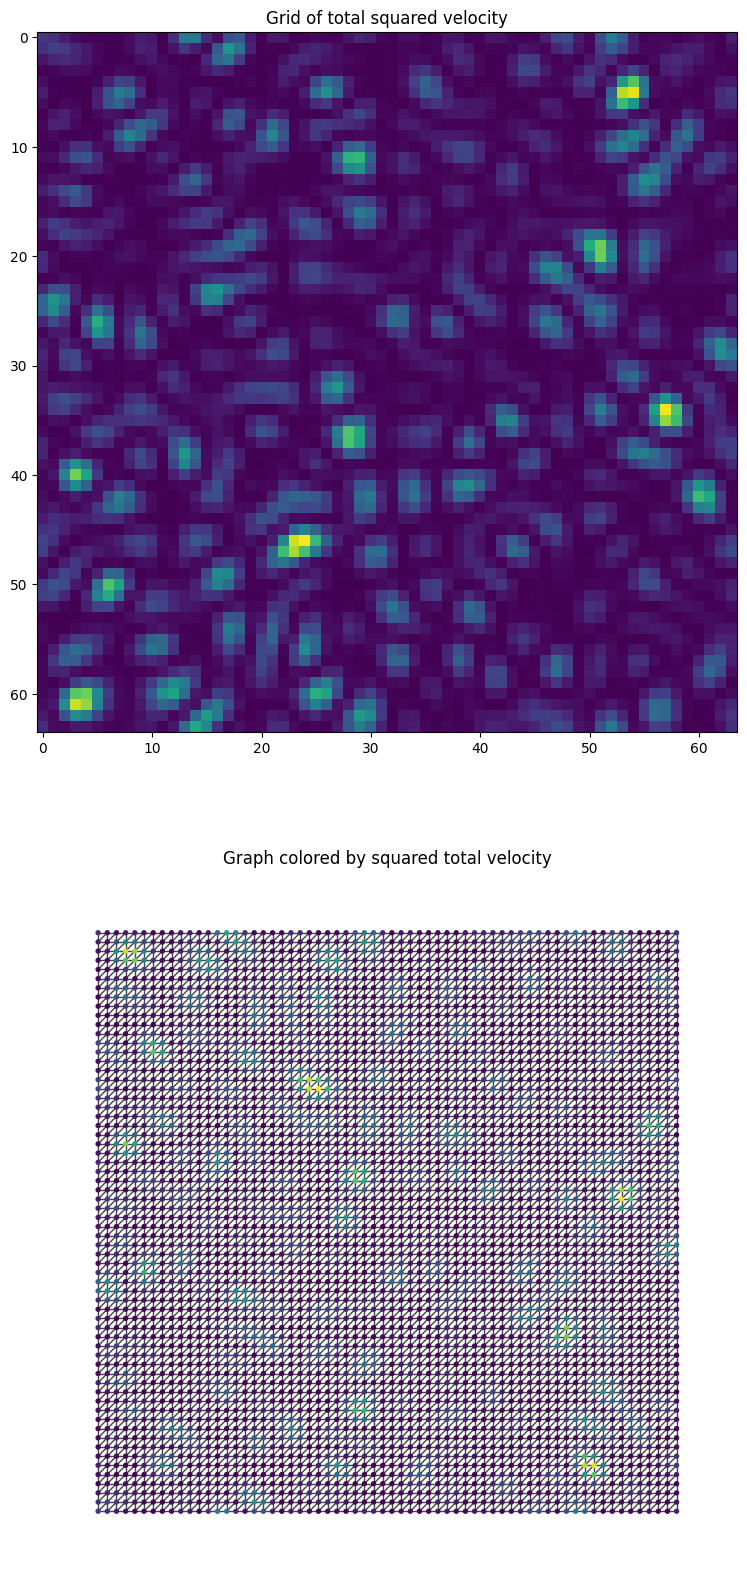

In [12]:
fig, axes = plt.subplots(2,1,figsize=(12,20))
axes[0].imshow(np.array(flow_reps_ex.node_energy_features()).reshape(64,64));
axes[0].set_title('Grid of total squared velocity')
flow_reps_ex.visualize_energy(ax=axes[1], node_size=8, edge_width=1)

## Conclusion

Scenario 1:
Our SNN performs X% better than the GNN at predicting the next frame of a fluid flow. We attribute this to the higher order features it can represent, providing more information to the model.

Scenario 2:
Our SNN performs about the same as the GNN baseline. The 'higher order' features of our model are somewhat contrived, as they are constructed from a regular grid and do not encode any additional meaning about the actual fluid flow. A more dynamic topology, for example one based on velocity vectors and eddies, might perform better as it encodes relevant information about the fluid.

Scenario 3:
Our SNN performs worse than the GNN baseline. The 'higher order' features of our model are somewhat contrived, as they are constructed from a regular grid and do not encode any additional meaning about the actual fluid flow, so these additional features add noise to the model and lead to worse performance.